In [1]:
import glob
import shutil
import os
import pathlib
import random
import math
import keras
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from PIL import Image, ImageOps
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
dataset_root_path = pathlib.Path('./dataset/')
dataset_root_path

PosixPath('dataset')

In [21]:
covid_dataset_path = dataset_root_path / 'COVID'
nonCovid_dataset_path = dataset_root_path / 'non-COVID'

train_dir = dataset_root_path / 'train'
test_dir = dataset_root_path / 'test'

In [24]:
covid_path, covid_dirs, covid_files = next(os.walk(covid_dataset_path))
covid_file_count = len(covid_files)

non_covid_path, non_covid_dirs, non_covid_files = next(os.walk(nonCovid_dataset_path))
non_covid_file_count = len(non_covid_files)

print('Total Number of COVID images: ', covid_file_count)
print('Total Number of non-COVID images: ', non_covid_file_count)

print('We are taking 20% of the entire dataset as test set')

covid_test_count = math.ceil(0.2*covid_file_count)
non_covid_test_count = math.ceil(0.2*non_covid_file_count)

print('Number of train images: ', (covid_file_count+non_covid_file_count)-(covid_test_count+non_covid_test_count))
print('Number of test images: ', (covid_test_count+non_covid_test_count))


Total Number of COVID images:  1252
Total Number of non-COVID images:  1229
We are taking 20% of the entire dataset as test set
Number of train images:  1984
Number of test images:  497


In [51]:
# Copy images to train and test folder

df_train = pd.DataFrame()
df_test = pd.DataFrame()
covid_image_counter = 0
nonCovid_image_counter = 0
train_counter = 0
test_counter = 0

for jpgfile in glob.iglob(os.path.join(covid_dataset_path, "*.png")):
    if covid_image_counter < covid_test_count:
        shutil.copy(jpgfile, test_dir)
        df_test.loc[test_counter, 'Image_Name'] = jpgfile[14:]
        df_test.loc[test_counter, 'Reported'] = 0
        covid_image_counter += 1
        test_counter += 1
    else:
        shutil.copy(jpgfile, train_dir)
        df_train.loc[train_counter, 'Image_Name'] = jpgfile[14:]
        df_train.loc[train_counter, 'Reported'] = 0
        covid_image_counter += 1
        train_counter += 1
    
for jpgfile in glob.iglob(os.path.join(nonCovid_dataset_path, "*.png")):
    if nonCovid_image_counter < non_covid_test_count:
        shutil.copy(jpgfile, test_dir)
        df_test.loc[test_counter, 'Image_Name'] = jpgfile[18:]
        df_test.loc[test_counter, 'Reported'] = 1
        test_counter += 1
        nonCovid_image_counter += 1
    else:
        shutil.copy(jpgfile, train_dir)
        df_train.loc[train_counter, 'Image_Name'] = jpgfile[18:]
        df_train.loc[train_counter, 'Reported'] = 1
        train_counter += 1
        nonCovid_image_counter += 1

print('Transfer of Images complete')

Transfer of Images complete


In [52]:
df_train.to_csv('./dataset/train.csv', encoding='utf-8')
df_train

,Image_Name,Reported
0,Covid (397).png,0.0
1,Covid (801).png,0.0
2,Covid (45).png,0.0
3,Covid (2).png,0.0
4,Covid (102).png,0.0
...,...,...
1979,Non-Covid (1052).png,1.0
1980,Non-Covid (51).png,1.0
1981,Non-Covid (1117).png,1.0
1982,Non-Covid (671).png,1.0


In [53]:
df_test.to_csv('./dataset/test.csv', encoding='utf-8')
df_test

,Image_Name,Reported
0,Covid (640).png,0.0
1,Covid (210).png,0.0
2,Covid (705).png,0.0
3,Covid (355).png,0.0
4,Covid (586).png,0.0
...,...,...
492,Non-Covid (624).png,1.0
493,Non-Covid (331).png,1.0
494,Non-Covid (761).png,1.0
495,Non-Covid (1007).png,1.0


In [54]:
df_train = pd.read_csv(pathlib.Path(dataset_root_path, 'train.csv'))
df_test = pd.read_csv(pathlib.Path(dataset_root_path, 'test.csv'))

In [55]:
train_images = []

for train_id in df_train['Image_Name']:
    #im = plt.imread(pathlib.Path(train_dir, train_id))
    im = Image.open(pathlib.Path(train_dir, train_id))
    im = im.resize((255, 255)).convert('RGB')
    print(im)
    train_images.append(np.asarray(im))
  

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CF50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081C50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212410>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CD90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DFA1350>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CED0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFD7510>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E20C550>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DFA1350>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBF0D0>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528C50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477D50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477D50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477250>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528C50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2090>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477D50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2C90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87250>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2750>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2C90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2D90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BE10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BE10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BE10>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0838D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083590>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083650>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081D10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083650>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083650>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0838D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083650>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8DB37C51D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E240A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E240A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E240A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083410>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87B90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477DD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477D90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477D90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF737D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99527A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87B90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87B90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF737D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DFA1990>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF737D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF737D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8DB37C51D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9F2EFC50>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CF87350>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B1D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B1D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBF350>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E232210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBF350>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBFC10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFD7510>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CF87350>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E232210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212210>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CF87190>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081F90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081C50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0833D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081C50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0833D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083550>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0838D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083490>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083F90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083B50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083110>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083DD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083310>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083B50>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477CD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477A90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094F10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094F10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477CD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9F202D10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477A90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9F202D10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477690>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995274D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995274D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A6D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995274D0>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBFC10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520810>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99527250>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528B90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520810>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBFC10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520590>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520810>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520590>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520590>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBFC10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E240A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99520810>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083650>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083390>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094DD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094410>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094990>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094650>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094990>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094410>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9F2EFC50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D994C2ED0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9ABD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E094DD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0949D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0949D0>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083C90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EC192D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083390>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CD90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EC19F10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E083150>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CD90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528D10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EC19F10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212F50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E212410>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EC19F10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528D10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DF6FC90>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B090>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CD90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBF410>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B090>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBFA90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04CD90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBFA90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477CD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D98863BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99528790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9952CCD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9CFBF410>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BF90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9F2EFC50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995278D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995278D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995278D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995278D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995278D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E232210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D99477710>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D995278D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E08C110>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E232210>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87A10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DE87A10>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081B50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081710>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081490>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0815D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081B50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081490>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081810>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E0815D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E081710>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9EF9A790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E09CA90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B0D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B950>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B950>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BED0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E04C050>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BED0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9952CCD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9952CCD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BBD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951BBD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B0D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9952CCD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9951B950>
<PIL.Image.Image image mode=RGB size=255

In [56]:
train_images = np.asarray(train_images)

X = train_images
y = df_train['Reported']

print("Labels: ", y.shape)
print("images: ", X.shape)

Labels:  (1984,)
images:  (1984, 255, 255, 3)


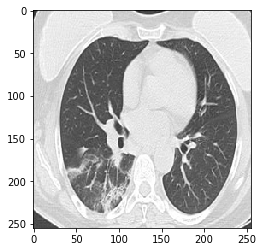

In [57]:
plt.imshow(X[1])

In [49]:
def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(255, 255, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

Cat_val_y = np_utils.to_categorical(y_val)
y_train = np_utils.to_categorical(y_train)

print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_val.shape)
print("y_test shape : ",y_val.shape)

X_train shape :  (1329, 255, 255, 3)
y_train shape :  (1329, 2)
X_test shape :  (655, 255, 255, 3)
y_test shape :  (655,)


In [59]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 2
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 255, 255, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 24) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 24) 0           activation_1[0][0]               
_________

In [60]:
history = model.fit(
    X_train,
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, shuffle=True,
    validation_data=(X_val, Cat_val_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1329 samples, validate on 655 samples
Epoch 1/10
1329/1329 [==============================] - 563s 424ms/step - loss: 0.5858 - accuracy: 0.7178 - val_loss: 4.4857 - val_accuracy: 0.4977
Epoch 2/10
1329/1329 [==============================] - 534s 402ms/step - loss: 0.5028 - accuracy: 0.7743 - val_loss: 2.8353 - val_accuracy: 0.4977
Epoch 3/10
1329/1329 [==============================] - 388s 292ms/step - loss: 0.4771 - accuracy: 0.7788 - val_loss: 2.1083 - val_accuracy: 0.4977
Epoch 4/10
1329/1329 [==============================] - 353s 266ms/step - loss: 0.4645 - accuracy: 0.7871 - val_loss: 0.6871 - val_accuracy: 0.5985
Epoch 5/10
1329/1329 [==============================] - 353s 266ms/step - loss: 0.4355 - accuracy: 0.8104 - val_loss: 0.5439 - val_accuracy: 0.7328
Epoch 6/10
1329/1329 [==============================] - 356s 268ms/step - loss: 0.4259 - accuracy: 0.7991 - val_loss: 

Generating plots...


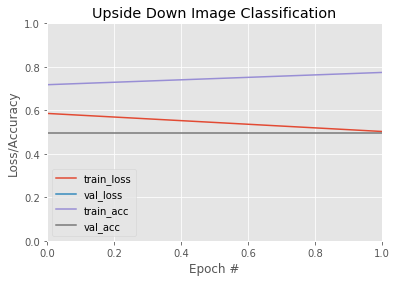

In [64]:
print("Generating plots...")
sys.stdout.flush()
#matplotlib.use("Agg")
plt.style.use("ggplot")
plt.figure()
N = epochs 
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Upside Down Image Classification")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig("plot.png")

In [68]:
test_images = []

for test_id in df_test['Image_Name']:
    #im = plt.imread(pathlib.Path(train_dir, train_id))
    im = Image.open(pathlib.Path(test_dir, test_id))
    im = im.resize((255, 255)).convert('RGB')
    print(im)
    test_images.append(np.asarray(im))

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE921FC50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE921FC50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE921F4D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F9B2D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8523BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE921F2D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE9039390>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8523BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE900F810>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D980C5B10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9E118450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8523BD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F993D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE9039390>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE78C40D0>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE923D450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F91750>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE881A990>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F91890>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F99B50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F99C10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F99B50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F99B50>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F91890>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F99790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE881A990>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F99790>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F91750>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F8BCD0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F1EED0>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13950>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13B10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13B10>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13390>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F132D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13550>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F136D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F132D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13150>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13550>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13250>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F13690>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F136D0>
<PIL.Image.Image image mode=RGB size=255

<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F332D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F33450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F33A90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F332D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F332D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE902A3D0>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DC9BD90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE902A250>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F33A90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F2F850>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE902A250>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F33A90>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE6F2A110>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8BE8F33450>
<PIL.Image.Image image mode=RGB size=255x255 at 0x7F8D9DC9BD90>
<PIL.Image.Image image mode=RGB size=255

In [69]:
test_images = np.asarray(test_images)

X_test = test_images
y_test = df_test['Reported']
Cat_test_y = np_utils.to_categorical(y_test)

In [70]:
label_pred = model.predict(X_test)
print(label_pred)

[[9.35347378e-01 6.46526366e-02]
 [9.14156079e-01 8.58438984e-02]
 [9.98220742e-01 1.77924323e-03]
 [9.90872562e-01 9.12744831e-03]
 [9.65630531e-01 3.43695283e-02]
 [9.99336183e-01 6.63742481e-04]
 [9.98947203e-01 1.05283840e-03]
 [9.99912620e-01 8.73472673e-05]
 [9.97030497e-01 2.96943379e-03]
 [9.81627524e-01 1.83724407e-02]
 [9.83730316e-01 1.62696969e-02]
 [9.99968648e-01 3.13169185e-05]
 [9.67948198e-01 3.20517309e-02]
 [9.51616645e-01 4.83834296e-02]
 [9.78769660e-01 2.12303679e-02]
 [8.25519145e-01 1.74480796e-01]
 [9.26505864e-01 7.34941363e-02]
 [9.20809925e-01 7.91900903e-02]
 [9.88020480e-01 1.19795399e-02]
 [9.99398589e-01 6.01415639e-04]
 [9.72952783e-01 2.70472076e-02]
 [9.54354048e-01 4.56459038e-02]
 [9.97985959e-01 2.01407401e-03]
 [9.99985933e-01 1.40621669e-05]
 [9.83164370e-01 1.68356057e-02]
 [9.84130442e-01 1.58695914e-02]
 [9.43678498e-01 5.63215464e-02]
 [9.71355438e-01 2.86446288e-02]
 [9.48037446e-01 5.19625954e-02]
 [9.73183274e-01 2.68167406e-02]
 [9.671862

In [71]:
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1)

print(metrics.classification_report(Y_test, pred))


              precision    recall  f1-score   support

           0       0.60      1.00      0.75       251
           1       1.00      0.31      0.48       246

    accuracy                           0.66       497
   macro avg       0.80      0.66      0.61       497
weighted avg       0.80      0.66      0.61       497

